# Relax Inc. Data Science Sample Take Home Challenge
The  data  is  available  as  two  attached  CSV  files:  
1. takehome_user_engagement. csv
2. takehome_users . csv
The  data  has  the  following  two  tables:  
1.   A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the product  in  the  last  two  years.   
This  table  includes:
* name:  the  user's  name
* object_id:   the  user's  id
* email:  email  address
* creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
  - PERSONAL_PROJECTS:  invited  to  join  another  user's personal  workspace
  - GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
  - ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
  - SIGNUP:  signed  up  via  the  website
  - SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  login id)
* creation_time:  when  they  created  their  account
* last_session_creation_time:   unix  timestamp  of  last  login
* opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
* enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
* org_id:   the  organization  (group  of  users)  they  belong  to
* invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

2. A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day that  a  user  logged  into  the  product.


Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user adoption. We  suggest  spending  1-2  hours  on  this,  but  you're  welcome  to  spend  more  or  less. Please  send  us  a  brief  writeup  of  your  findings  (the  more  concise,  the  better  --  no  more than  one  page),  along  with  any  summary  tables,  graphs,  code,  or  queries  that  can  help us  understand  your  approach.  Please  note  any  factors  you  considered  or  investigation you  did,  even  if  they  did  not  pan  out.  Feel  free  to  identify  any  further  research  or  data you  think  would  be  valuable.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

In [2]:
# Definition of functions

def updated_dict(d, **kwargs):
    updated_d = d.copy()
    updated_d.update(kwargs)
    return updated_d

def clean_func_names(df):
    df = df.copy()   
    columns = [c for c in df.columns if callable(df[c][0])] 
    for c in columns:
        funcs = []
        for train in df[c]:
            funcs.append(train.__name__)
        df[c] = funcs
    return df
    

In [3]:
# Load DataFrame with feature 'time_stamp' as datetime
engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [6]:
# Latest time stamp
engagement.time_stamp.max()

Timestamp('2014-06-06 14:58:50')

In [7]:
# Oldest time stamp
engagement.time_stamp.min()

Timestamp('2012-05-31 08:20:06')

In [8]:
# Load DataFrame with feature 'creation_time' as datetime
users_df = pd.read_csv('takehome_users.csv',encoding='latin',parse_dates=['creation_time'])
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [10]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [11]:
# Full outer join of the 2 tables
data_df = engagement.merge(users_df, left_on='user_id', right_on='object_id', how='outer')

# Remove duplicate/unnecessary columns. 'visited' only has 1 for an entry, trivial column.
del data_df['object_id'], data_df['visited']

In [12]:
data_df.head()

,time_stamp,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1.0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2013-11-15 03:45:04,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,2013-11-29 03:45:04,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-12-09 03:45:04,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
4,2013-12-25 03:45:04,2.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [13]:
data_df.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,207917.000000,2.079170e+05,211094.000000,211094.000000,211094.000000,118528.000000
mean,5913.314197,1.399439e+09,0.257890,0.154344,163.949558,5971.333347
std,3394.941674,8.294017e+06,0.437474,0.361279,121.240661,3248.588044
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3087.000000,1.401045e+09,0.000000,0.000000,60.000000,3269.000000
50%,5682.000000,1.401665e+09,0.000000,0.000000,145.000000,5972.000000
75%,8944.000000,1.401868e+09,1.000000,0.000000,260.000000,8513.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 11 columns):
time_stamp                    207917 non-null datetime64[ns]
user_id                       207917 non-null float64
creation_time                 211094 non-null datetime64[ns]
name                          211094 non-null object
email                         211094 non-null object
creation_source               211094 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      211094 non-null int64
enabled_for_marketing_drip    211094 non-null int64
org_id                        211094 non-null int64
invited_by_user_id            118528 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(3), object(3)
memory usage: 19.3+ MB


In [15]:
# If a user is not invited by another user, we give this column a value of 0
data_df.loc[np.isnan(data_df['invited_by_user_id']), 'invited_by_user_id'] = 0

# Drow rows with mostly NaN values
data_df = data_df.dropna()

# Correcting Data Types
data_df['user_id'] = data_df['user_id'].astype(int)
data_df['invited_by_user_id'] = data_df['invited_by_user_id'].astype(int)


In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 11 columns):
time_stamp                    207917 non-null datetime64[ns]
user_id                       207917 non-null int32
creation_time                 207917 non-null datetime64[ns]
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            207917 non-null int32
dtypes: datetime64[ns](2), float64(1), int32(2), int64(3), object(3)
memory usage: 17.4+ MB


Create 'adopted user' feature.

In [17]:
data_df

,time_stamp,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803
1,2013-11-15 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
2,2013-11-29 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
3,2013-12-09 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
4,2013-12-25 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
5,2013-12-31 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
6,2014-01-08 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
7,2014-02-03 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
8,2014-02-08 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
9,2014-02-09 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316


In [18]:
# Initially set all users as not 'adopted' (0 is false, 1 is true).
data_df['adopted_user'] = 0

# Data of users and how many times each of them have logged in. 
num_logins = data_df['name'].value_counts().values

# Names of users who logged in 3 or more times
valid_users = data_df['name'].value_counts().index[0:len(num_logins[num_logins>=3])]

# Setting a variable to aggregate over
data_df['counter'] = 1
user_labels = []

for idx, user in enumerate(valid_users): 
    user_df = data_df[data_df.name==user]
    # Maximum number of logins in any week for each user
    max_logins = user_df.set_index("time_stamp").resample("7D").sum().dropna()['counter'].max()
    
    if max_logins>=3:
        user_labels.append(1)
    else:
        user_labels.append(0)

# Extracting names of users who are considered 'adopted', and the total num of adopted users
adopted_user_names = valid_users[np.where(np.array(user_labels)==1)]
num_adopted_users = len(adopted_user_names)

# Deleting aggregation counter
del data_df['counter']

# Giving the 'adopted users' their appropriate labels
data_df.loc[data_df['name'].isin(adopted_user_names), 'adopted_user'] = 1

# Do the same for the users dataframe
users_df['adopted_user'] = 0
users_df.loc[users_df['name'].isin(adopted_user_names), 'adopted_user'] = 1

In [19]:
data_df

,time_stamp,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,2014-04-22 03:53:30,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803,0
1,2013-11-15 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
2,2013-11-29 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
3,2013-12-09 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
4,2013-12-25 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
5,2013-12-31 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
6,2014-01-08 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
7,2014-02-03 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
8,2014-02-08 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1
9,2014-02-09 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316,1


In [20]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 12 columns):
time_stamp                    207917 non-null datetime64[ns]
user_id                       207917 non-null int32
creation_time                 207917 non-null datetime64[ns]
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            207917 non-null int32
adopted_user                  207917 non-null int64
dtypes: datetime64[ns](2), float64(1), int32(2), int64(4), object(3)
memory usage: 19.0+ MB


In [21]:
# One-hot-encode creation_source
data_df = pd.get_dummies(data_df, columns = ['creation_source'])
data_df.head()

,time_stamp,user_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,2014-04-22 03:53:30,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803,0,1,0,0,0,0
1,2013-11-15 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,1,0,1,0,0,0
2,2013-11-29 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,1,0,1,0,0,0
3,2013-12-09 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,1,0,1,0,0,0
4,2013-12-25 03:45:04,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316,1,0,1,0,0,0


In [22]:
data_df.columns

Index(['time_stamp', 'user_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted_user', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

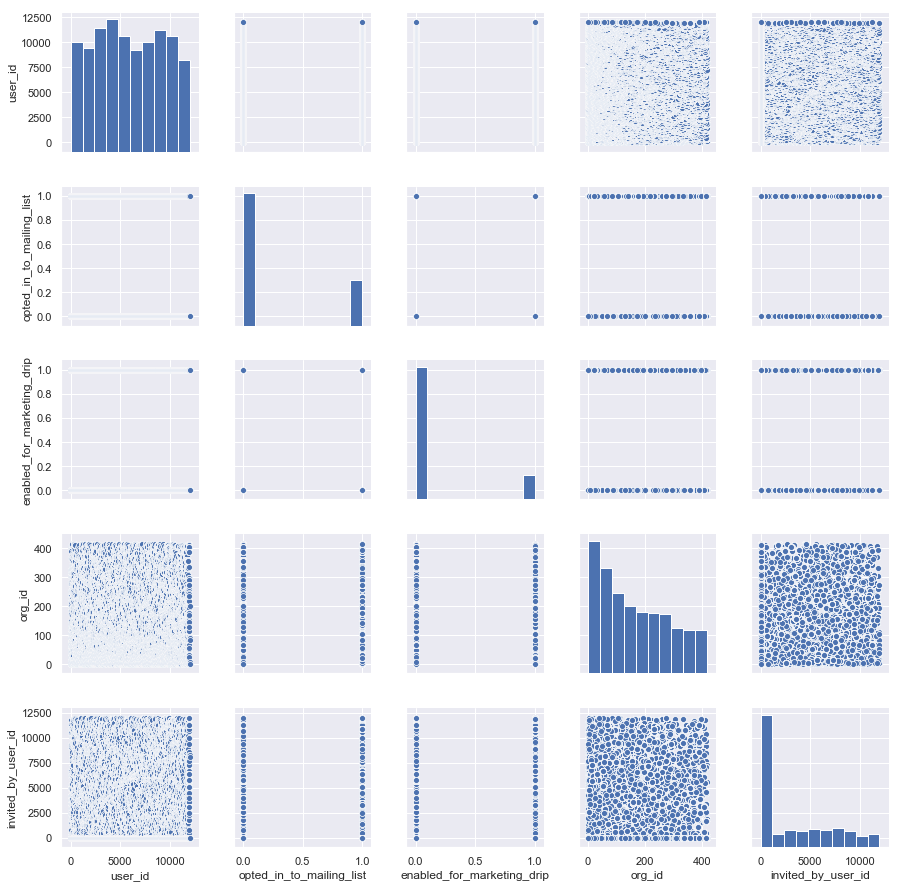

In [23]:
#scatterplot
sns.set() 
cols = ['user_id', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
sns.pairplot(data_df[cols])
plt.show()

In [24]:
# Getting distinct values of domain of the email
abc = []
for i in range(len(data_df.email)):
    a = data_df.email[i].split('@')[1]
    abc.append(a)
print(len(list(set(abc))))

812


There are too many domain (812) therefore we will not proceed with this information.

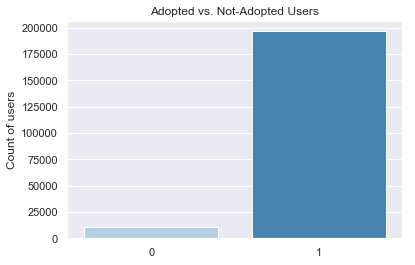

In [25]:
# Take another look at the distribution of the target class
sns.barplot(x = list(data_df['adopted_user'].value_counts().index), y = data_df['adopted_user'].value_counts(), palette='Blues')
plt.ylabel('Count of users')
plt.title('Adopted vs. Not-Adopted Users')
plt.show()

We are delaing with imbalanced dataset. In our model prediction we have to be careful about this - either we have to oversample/undersample or for initial inside we take classifier which will take care of imbalanced dataset for us, using a parameter class_weight='balanced'.   
We drop some columns, such as datetime columns, and then columns 'user_id', 'name' and 'email' to preent leakage of data. 

In [26]:
data_df.drop(['user_id','time_stamp', 'last_session_creation_time', 'creation_time', 'name', 'email' ],axis=1,  inplace=True)

In [27]:
data_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,0,1,0,0,0,0
1,0,0,1,316,1,0,1,0,0,0
2,0,0,1,316,1,0,1,0,0,0
3,0,0,1,316,1,0,1,0,0,0
4,0,0,1,316,1,0,1,0,0,0


In [28]:
data_df.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted_user', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [29]:
y = data_df['adopted_user']
X = data_df.drop('adopted_user', axis=1)

In [30]:
X.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

Split our dataset test:train = 20:80, and try models with Random Forest classifier.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

In [32]:
def train_random(X_train_sc, y_train, **kwargs):
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', 
                                 bootstrap=kwargs.get('bootstrap', 'True'),
                                 n_estimators=kwargs.get('n_estimators', 100))
   
    model = clf.fit(X_train_sc, y_train)
    return model

In [33]:
# return as pandas series, with multiple evaulation metrcis (fp, tn, fn, tp)
def eval_model(X_test_sc, y_test, X_train_sc, y_train):
    hp['f1_score'] = f1_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    hp['recall'] = recall_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    hp['precision'] = precision_score(y_test, model.predict(X_test_sc), average='weighted', labels=np.unique(model.predict(X_test_sc)))
    return hp

In [35]:
scores = []
RF_def_hyperpar = dict(train_function=train_random, bootstrap=True, n_estimators=1)

RF_hyperparameters =[RF_def_hyperpar,updated_dict(RF_def_hyperpar, n_estimators=10),
                     updated_dict(RF_def_hyperpar, n_estimators=20),
                     updated_dict(RF_def_hyperpar, n_estimators=50),
                     updated_dict(RF_def_hyperpar, n_estimators=100), 
                     updated_dict(RF_def_hyperpar,bootstrap=False),
                     updated_dict(RF_def_hyperpar,n_estimators=1),
                     updated_dict(RF_def_hyperpar,n_estimators=1000),
                     updated_dict(RF_def_hyperpar,n_estimators=50),
                     updated_dict(RF_def_hyperpar,n_estimators=1000, bootstrap=False)
                    ]


start_time = time.time()
for hyperparameters in RF_hyperparameters:#(logreg_hyperparameters + RF_hyperparameters): 
    hp = RF_def_hyperpar.copy()
    hp.update(hyperparameters)
    train = hp.get('train_function')
    print(hp)
    model = train(X_train, y_train, **hp)
    hp = eval_model(X_test, y_test, X_train, y_train)
    scores.append(hp)
print("I am done!")
print("--- %s seconds ---" % (time.time() - start_time))

{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 1}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 10}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 20}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 50}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 100}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': False, 'n_estimators': 1}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 1}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 1000}
{'train_function': <function train_random at 0x0000020102662F28>, 'bootstrap': True, 'n_estimators': 50}
{'train_function': <function train_random at 0x0000020

In [36]:
new = clean_func_names(pd.DataFrame(scores))
new

,bootstrap,f1_score,n_estimators,precision,recall,train_function
0,True,0.955063,1,0.963576,0.950125,train_random
1,True,0.963704,10,0.969588,0.960442,train_random
2,True,0.962978,20,0.969418,0.959456,train_random
3,True,0.963812,50,0.969681,0.960562,train_random
4,True,0.964038,100,0.969782,0.960850,train_random
5,False,0.958590,1,0.966977,0.953997,train_random
6,True,0.955063,1,0.963576,0.950125,train_random
7,True,0.963796,1000,0.969746,0.960514,train_random
8,True,0.963812,50,0.969681,0.960562,train_random
9,False,0.959698,1000,0.968424,0.955079,train_random


In [37]:
new.f1_score.nlargest(3)

4    0.964038
3    0.963812
8    0.963812
Name: f1_score, dtype: float64

In [38]:
rf_best = RandomForestClassifier(random_state=0, bootstrap=True, 
                                 class_weight='balanced', n_estimators=100)

rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [39]:
pd.DataFrame(zip(data_df.columns, rf_best.feature_importances_), columns=['Feature','Value']).\
   sort_values('Value', ascending=False).reset_index(drop=True)

,Feature,Value
0,org_id,0.641598
1,invited_by_user_id,0.312268
2,opted_in_to_mailing_list,0.014673
3,enabled_for_marketing_drip,0.013425
4,creation_source_SIGNUP,0.003856
5,adopted_user,0.003731
6,creation_source_GUEST_INVITE,0.003645
7,creation_source_PERSONAL_PROJECTS,0.003524
8,creation_source_ORG_INVITE,0.003279


Feature with highest importance is 'org_id' and the other high impact factor is 'invited_by_user_id' and therefore it should be encourage that active users keep inviting new users.